# Classification of Objects using COCO Dataset

#### COCO is a large-scale object detection, segmentation, and captioning dataset. 

#### The dataset in for this notebook was stored in the directory:  
D:/pythonProject/COCOAssignment

Change the directory to the appropriate directory when running this notebook  
This code is also written to support CUDA devices.

### Import the libraries

In [1]:
from pycocotools.coco import COCO
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, IterableDataset, random_split
from torchvision import transforms
from torch.optim import Adam
from PIL import Image

### Setting device to CUDA devices if the system has CUDA support

In [2]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

### Transformation steps
Data Normalization is performed because neural networks tend to perform better when working with data that has a mean close to zero. The division by the standard deviation scales the data, which can help in reducing the risk of vanishing or exploding gradients during training.


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

The mean and standard deviation was selected to be the these values in accordance with the ImageNet dataset, and they work well as good starting points for normalizing images across a wide range of computer vision tasks.

In [4]:
# Set the generator's device to CUDA if available
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Defining the get_image_data() function which parses the annotation files and creates a dataset in the format of:  
custom_data = [
('path_to_image1.jpg', 0),  
('path_to_image2.jpg', 1),  
('path_to_image3.jpg', 2),  
...  
]

Change the dataDir path to the location of the COCO dataset

In [5]:
def get_image_data():
    
    dataDir = 'D:/pythonProject/COCOAssignment'
    dataType = 'val2014'
    annFile = f'{dataDir}/annotations/instances_{dataType}.json'
    imageDir = f'{dataDir}/{dataType}'

    coco = COCO(annFile)
    custom_data = []

    for img_id in coco.getImgIds():
        img_info = coco.loadImgs(img_id)[0]
        img_path = f'{imageDir}/{img_info["file_name"]}'

        ann_ids = coco.getAnnIds(imgIds=img_info['id'])
        annotations = coco.loadAnns(ann_ids)

        labels = [ann['category_id'] for ann in annotations]

        if len(labels) > 0:
            custom_data.append((img_path, labels[0]))

    return custom_data
custom_data = get_image_data()

loading annotations into memory...
Done (t=4.30s)
creating index...
index created!


### Creating a custom generator with shuffling support
A custom generator was created as the Dataset class from torch was running into errors for CUDA support

In [6]:
def custom_generator(data, transform=None, shuffle=True):
    if shuffle:
        random.shuffle(data)  # Shuffle the data before yielding
    for image_path, label in data:
        image = Image.open(image_path).convert('RGB')
        if transform:
            image = transform(image)
        yield image, label


### Creating a CustomIterable class with the custom generator as the iterator

In [7]:
class CustomIterableMultiClassDataset(IterableDataset):
    def __init__(self, data, transform=None, shuffle=True):
        self.data = data
        self.transform = transform
        self.shuffle = shuffle

    def __iter__(self):
        return custom_generator(self.data, transform=self.transform, shuffle=self.shuffle)

### Splitting the data into train and test data after shuffling the data
80% of the data is train data  
20% is test data

In [8]:
random.shuffle(custom_data)  
train_size = int(0.8 * len(custom_data)) 
train_data = custom_data[:train_size]
test_data = custom_data[train_size:]

### Creating a DataLoader for the training and test datasets

In [9]:
batch_size = 32

train_dataset = CustomIterableMultiClassDataset(train_data, transform=transform, shuffle=True)
test_dataset = CustomIterableMultiClassDataset(test_data, transform=transform, shuffle=False)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

### Defining the Multiclass Classifier

The classifier model in here is trained via transfer learning.  
A pretrained model of the Resnet-18 image classifier is taken and the last fully connected layer is replaced according to the COCO datset. We then train this model

In [10]:
class MultiClassClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
        self.resnet.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        return self.resnet(x)

### Initialize the model, the loss function, the optimizer and the number of epochs  
The model is initialized and moved into the CUDA device
For this model we ise the CrossEntropyLoss and the Adam Optimizer  
CrossEntropyLoss is well suited for MultiClass Classification tasks. Furthermore it provides gradients that are well-suited for gradient descent optimization.
Adam Optimizer automatically adjusts the learning rate for each parameter during training based on past gradient information. This helps with faster convergence and improved stability

In [11]:
num_classes = 91
model = MultiClassClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 100

Using cache found in C:\Users\HP/.cache\torch\hub\pytorch_vision_v0.9.0


### Training of the model

In [12]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    num_iterations = len(train_data) // batch_size  # Calculate the number of iterations per epoch
    for i, (images, labels) in enumerate(train_data_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Total Loss: {total_loss / num_iterations}")

Epoch [1/100] - Total Loss: 2.6665885190545384
Epoch [2/100] - Total Loss: 2.2283001440472283
Epoch [3/100] - Total Loss: 1.9658497628994502
Epoch [4/100] - Total Loss: 1.7031372978703925
Epoch [5/100] - Total Loss: 1.3806307608204136
Epoch [6/100] - Total Loss: 1.012043317258061
Epoch [7/100] - Total Loss: 0.6597610647573785
Epoch [8/100] - Total Loss: 0.4190352793378107
Epoch [9/100] - Total Loss: 0.3314647491230209
Epoch [10/100] - Total Loss: 0.2625293164669071
Epoch [11/100] - Total Loss: 0.23235059464359628
Epoch [12/100] - Total Loss: 0.22682188561600322
Epoch [13/100] - Total Loss: 0.1640520707898191
Epoch [14/100] - Total Loss: 0.18336902071414507
Epoch [15/100] - Total Loss: 0.18378045459594558
Epoch [16/100] - Total Loss: 0.1469383264064477
Epoch [17/100] - Total Loss: 0.1517165979467507
Epoch [18/100] - Total Loss: 0.14318124156497264
Epoch [19/100] - Total Loss: 0.1318731700818371
Epoch [20/100] - Total Loss: 0.12219873403156305
Epoch [21/100] - Total Loss: 0.1180941099569

### Calculating the accuracy of the model against test dataset

In [13]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 37.42%


### Save the trained model

In [15]:
torch.save(model.state_dict(), 'trained_model.pth')

### For feature based similarity and retrieving,  
we can input an image to the model and find the category. After that we can retrieve an image from out training set from the same category

#### Importing libraries and loading the annotation files

In [35]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [18]:
dataDir = 'D:/pythonProject/COCOAssignment'
dataType = 'val2014'
annFile = f'{dataDir}/annotations/instances_{dataType}.json'
imageDir = f'{dataDir}/{dataType}'
coco = COCO(annFile)

loading annotations into memory...
Done (t=4.94s)
creating index...
index created!


#### Loading the input image for model  
Here we are loading and displaying an image.

In [57]:
imgIds = coco.getImgIds(imgIds = [491556])
img = coco.loadImgs(imgIds[0])[0]

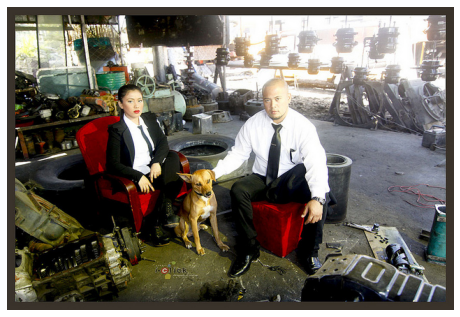

In [58]:
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

#### Preprocessing the input image as per the model requirements

In [59]:
image_path = f'{dataDir}/{dataType}/{img["file_name"]}'

image = Image.open(image_path).convert('RGB')
image = transform(image)
image = image.unsqueeze(0) # Add a batch dimension because we are processing a single image

#### Predicitng the category

In [60]:
with torch.no_grad():
    image = image.to(device)
    outputs = model(image)

_, predicted = torch.max(outputs, 1)
predicted_class = predicted.item()

#### Retrieving and dispalying another picture from the same category

In [61]:
imgIds = coco.getImgIds(catIds=[predicted_class] )

In [66]:
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

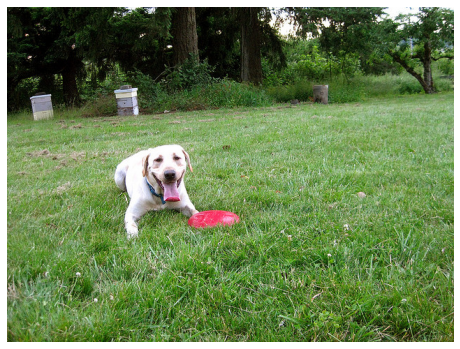

In [69]:
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()